In [18]:
# | output: false
# Setup Notebook

path = "../../../../scripts/notebook_header.py"
import os


if os.path.basename(os.getcwd()) != "mtg-modeling":
    args = f"--path {path}"
    get_ipython().run_line_magic("run", f"-i {path} {args}")  # type: ignore

In [19]:
import polars as pl
import matplotlib.pyplot as plt
import seaborn as sns

import src.plots.annotate as anno
import src.plots.symbols as symbols

In [20]:
set_code = "All_Sets"
set_codes_order = ["MKM", "OTJ", "MH3", "BLB"]

paths = {
    "processed": Path("data/processed/17lands/game_data/premier_draft"),
}
summary_file = paths["processed"] / f"{set_code}_Game_PD_Summary.parquet"
game_file = paths["processed"] / f"{set_code}_Game_PD_Games.parquet"
draft_file = paths["processed"] / f"{set_code}_Game_PD_Drafts.parquet"
card_file = paths["processed"] / f"{set_code}_Game_PD_Cards.parquet"

In [21]:
df_draft = pl.scan_parquet(draft_file)

# Introduction

This is a quick analysis to see the impact of rebuilding draft decks is related to win rates.  A player can rebuild their deck between games by utilizing their sideboard during a draft session. The theory is that better players will turn their decks, allowing for better win rates.  However, with the Premier Draft on MTG Arena, matches are only best-of-one.  So rebuilding is not as important as in Traditional Draft, which is best-of-three.  This analysis will look at the relationship between rebuilding and win rates.

This is a part of the MTG Arena draft analysis.  See the [Draft Introduction](00-intro.ipynb) for more information.  

# Builds

In @fig-n-games-rebuilds, we see that over 75% of draft sessions use the same deck build throughout. Only a tiny fraction of sessions feature more than two different builds.

In [22]:
builds = (
    df_draft.group_by(["n_builds", "expansion"])
    .agg(
        pl.col("n_wins").sum().alias("n_wins"),
        pl.col("n_games").sum().alias("n_games"),
    )
    .with_columns(
        (pl.col("n_wins") / pl.col("n_games")).alias("win_rate"),
        (pl.col("n_games") / pl.col("n_games").sum()).alias("pct_games"),
    )
    .sort(by=["expansion", "n_builds"], descending=True)
)

mean_win_rate = (
    builds.group_by("expansion")
    .agg(
        pl.col("n_games").sum().alias("set_n_games"),
        pl.col("n_wins").sum().alias("set_n_wins"),
    )
    .select(
        "expansion",
        "set_n_games",
        (pl.col("set_n_wins") / pl.col("set_n_games")).alias("set_win_rate"),
    )
)

builds = (
    builds.join(mean_win_rate, on="expansion")
    .with_columns(
        (pl.col("win_rate") / pl.col("set_win_rate")).alias("normalized_win_rate"),
        (pl.col("n_games") / pl.col("set_n_games")).alias("normalized_pct_games"),
    )
    .collect()
    .to_pandas()
)

builds = builds.loc[builds["n_builds"] <= 4]

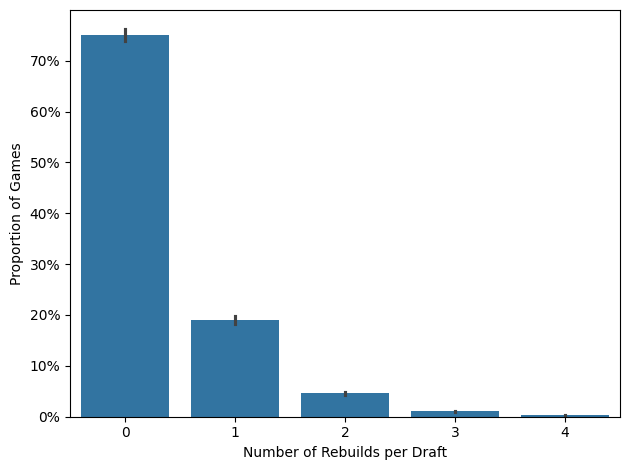

In [23]:
# | label: fig-n-games-rebuilds
# | fig-cap: "The proportion of games for the number of rebuilds.  Error bars are across sets."

sns.barplot(
    data=builds,
    x="n_builds",
    y="normalized_pct_games",
)
anno.set_labels_to_percent(axis="y")
anno.set_axis_labels_and_show(
    xlabel="Number of Rebuilds per Draft",
    ylabel="Proportion of Games",
)

In @fig-rebuilds-wins, we observe the relationship between win rate and the number of rebuilds. Decks with more rebuilds tend to have lower win rates, but it's unclear whether players are rebuilding more to salvage a poorly drafted deck or if rebuilding itself is a suboptimal strategy.

In [24]:
filtered_builds = builds.loc[builds["n_builds"] <= 3]

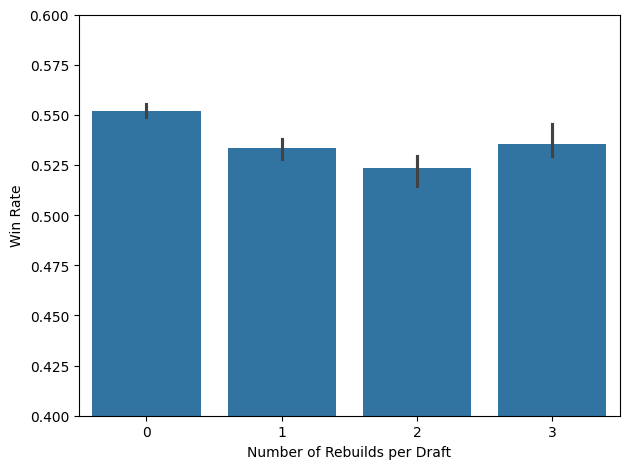

In [25]:
# | label: fig-rebuilds-wins
# | fig-cap: "The win rate for a number of deck rebuilds.  Error bars are across sets."

sns.barplot(data=filtered_builds, x="n_builds", y="win_rate")
plt.gca().set_ylim([0.4, 0.6])
# anno.set_labels_to_percent(axis="y")
anno.set_axis_labels_and_show(
    xlabel="Number of Rebuilds per Draft",
    ylabel="Win Rate",
)

# Conclusion

We have seen that rebuilding decks is not a common practice in MTG Arena drafts, at least for best-of-one matches.  The win rates for decks that are rebuilt more often are lower.  This could be due to players trying to fix a bad deck or that rebuilding is not a good strategy.  More analysis is needed to determine the cause of this relationship.